# (Quantum) Neural Networks

This notebook demonstrates the different generic (quantum) neural network implementations provided in Qiskit Machine Learning.
The networks are meant as application-anostic computational units that can be used in different use cases. 
Depending on the application, a particluar type of network might more or less suitable.
In the following, the different available networks will be discussed in more detail:

1. `NeuralNetwork`: The interface for neural networks.
2. `OpflowQNN`: A network based on the evaluation of quantum mechanical observables.
3. `TwoLayerQNN`: A special `OpflowQNN` implementation for convenience. 
3. `CircuitQNN`: A network based on the samples resulting from measuring a quantum circuit.

In [1]:
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance

In [2]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=100) 

## 1. `NeuralNetwork`

The `NeuralNetwork` represents the interface for all neural networks available in Qiskit Machine Learning.
It just exposes a forward and a backward pass taking the data samples and trainable weights as input.
A `NeuralNetwork` does not contain any training capabilities, these are pushed to the actual algorithms / applications. Thus, a `NeuralNetwork` also does not store the values for trainable weights. In the following, different implementations of this interfaces are introduced.

Suppose a `NeuralNetwork` called `nn`.
Then, the `nn.forward(input, weights)` pass takes either flat inputs for the data and weights of size `nn.num_inputs` and `nn.num_weights`, respectively, or corresponding batches.

## 2. `OpflowQNN`

In [3]:
from qiskit_machine_learning.neural_networks import OpflowQNN

In [4]:
# construct parametrized circuit
params1 = [Parameter('input1'), Parameter('weight1')]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc_sfn1 = StateFn(qc1)

# construct cost operator
H1 = StateFn(PauliSumOp.from_list([('Z', 1.0), ('X', 1.0)]))

# combine operator and circuit to objective function
op1 = ~H1 @ qc_sfn1
print(op1)

ComposedOp([
  OperatorMeasurement(1.0 * Z
  + 1.0 * X),
  CircuitStateFn(
       ┌───┐┌────────────┐┌─────────────┐
  q_0: ┤ H ├┤ RY(input1) ├┤ RX(weight1) ├
       └───┘└────────────┘└─────────────┘
  )
])


In [5]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters, 
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, [params1[0]], [params1[1]], expval, gradient, qi_sv)

In [6]:
# define (random) input and weights
input1 = np.random.rand(qnn1.num_inputs)
weights1 = np.random.rand(qnn1.num_weights)

In [7]:
# QNN forward pass
qnn1.forward(input1, weights1)

array(-0.11441526)

In [8]:
# QNN backward pass
qnn1.backward(input1, weights1)

(array([-1.40363879]), array([0.09887327]))

<font color="red">INCLUDE BATCHES...</font>

Combining multiple observables in a `ListOp` also allows to create more complex QNNs

In [9]:
op2 = ListOp([op1, op1])
qnn2 = OpflowQNN(op2, [params1[0]], [params1[1]], expval, gradient, qi_sv)

In [10]:
# QNN forward pass
qnn2.forward(input1, weights1)

array([-0.11441526, -0.11441526])

In [11]:
# QNN backward pass
qnn2.backward(input1, weights1)

(array([[-1.40363879],
        [-1.40363879]]),
 array([[0.09887327],
        [0.09887327]]))

## 3. `TwoLayerQNN`

The `TwoLayerQNN` is a special `OpflowQNN` on $n$ qubits that consists of first a feature map to insert data and second a variational form that is trained. The default observable is $Z^{\otimes n}$, i.e., parity.

In [12]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN

In [13]:
# specify the number of qubits
num_qubits = 3

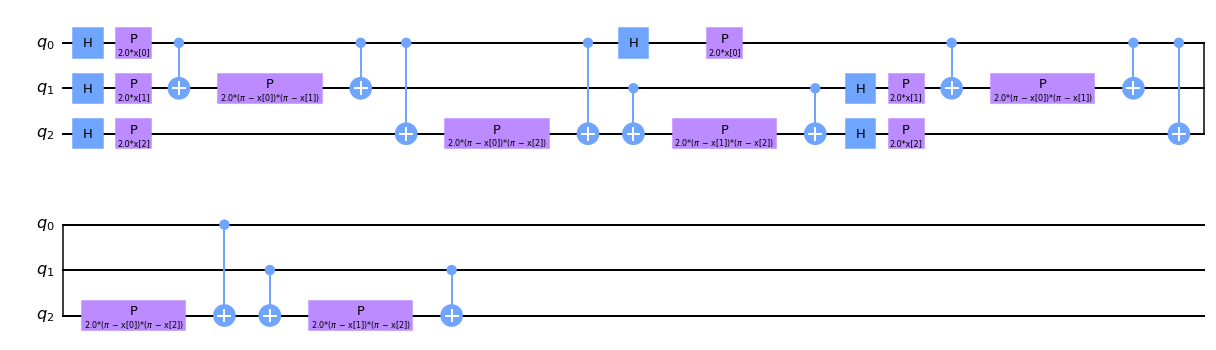

In [14]:
# specify the feature map
fm = ZZFeatureMap(num_qubits, reps=2)
fm.draw(output='mpl')

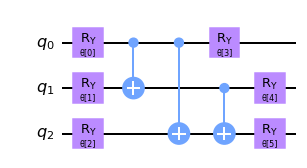

In [15]:
# specify the variational form
var_form = RealAmplitudes(num_qubits, reps=1)
var_form.draw(output='mpl')

In [16]:
# specify the observable
observable = PauliSumOp.from_list([('Z'*num_qubits, 1)])
print(observable)

1.0 * ZZZ


In [17]:
# define two layer QNN
qnn3 = TwoLayerQNN(num_qubits, 
                   feature_map=fm, 
                   var_form=var_form, 
                   observable=observable, quantum_instance=qi_sv)

In [18]:
# define (random) input and weights
input3 = np.random.rand(qnn3.num_inputs)
weights3 = np.random.rand(qnn3.num_weights)

In [19]:
# QNN forward pass
qnn3.forward(input3, weights3)

array(0.09968084)

In [20]:
# QNN backward pass
qnn3.backward(input3, weights3)

(array([-0.83005227, -3.71427661, -1.0165929 ]),
 array([-0.10379162, -0.16427914,  0.06400802, -0.09079179,  0.13462822,
         0.14374833]))

## 4. `CircuitQNN`

The `CircuitQNN` is just based on a (parametrized) `QuantumCircuit`. This can take input as well as weight parameters and produces samples from the measurement. The samples can either be interpreted as probabilities or directly as a batch of binary output. In the case of probabilities, gradients can be estimated efficiently and the `CircuitQNN` provides a backward pass as well. In case of samples, differentiation is not possible and the backward pass returns `(None, None)`.

Further, the `CircuitQNN` allows to specify different `interpret` options for the measured samples:
- 'int': interprets returns the measured bitstrings as integers
- 'str': returns the measured bitstrings
- 'tuple': returns the measured bitstrings as tuples
- a `callable`: applies a callable to the tuple of binaries and returns the result

The probabilities are then aggregated accordingly.

In case of `interpret='int'` or if `interpret` is set to a callable that returns non-negative integers, the `CircuitQNN` can be configured to return a dense instead of a sparse result.

<font color="red">output shape / dense / return types need to be further discussed</font>

<font color="red">what about `return_samples`?</font>

In [21]:
from qiskit_machine_learning.neural_networks import CircuitQNN

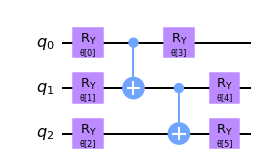

In [22]:
qc = RealAmplitudes(num_qubits, entanglement='linear', reps=1)
qc.draw(output='mpl')

### 4.1 Output: sparse integer probabilities

In [23]:
# specify circuit QNN
qnn4 = CircuitQNN(qc, [], qc.parameters, interpret='int', dense=False, quantum_instance=qi_qasm)

In [24]:
# define (random) input and weights
input4 = np.random.rand(qnn4.num_inputs)
weights4 = np.random.rand(qnn4.num_weights)

In [25]:
# QNN forward pass
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
qnn4.forward(input4, weights4)

{5: 0.01, 6: 0.26, 1: 0.12, 4: 0.15, 7: 0.2, 2: 0.03, 0: 0.23}

In [26]:
# QNN backward pass
qnn4.backward(input4, weights4)

([],
 [{0: -0.1282815741458147,
   1: 0.06650750981862542,
   2: -0.006273059496000748,
   3: -0.0004513907663595627,
   4: -0.03638247623629842,
   5: -0.010101324096631482,
   6: -0.22357413390544345,
   7: 0.3385564488279228},
  {0: -0.14391111033753262,
   1: 0.00988664428160219,
   2: -0.03136101166943031,
   3: -0.0009677830393487862,
   4: -0.2505462404184589,
   5: -0.008722853121063563,
   6: 0.3291809068111871,
   7: 0.09644144749304498},
  {0: -0.33514647904020817,
   1: -0.11186602518307846,
   2: 0.015074719334181011,
   3: 0.014051587634039403,
   4: 0.21439313097607793,
   5: 0.04156560699850315,
   6: 0.10567862872994926,
   7: 0.05624883055053591},
  {0: -0.15240460330618066,
   1: 0.15240460330618066,
   2: -0.010219212006670097,
   3: 0.010219212006670104,
   4: -0.06707845434984035,
   5: 0.06707845434984036,
   6: -0.19964935378020152,
   7: 0.19964935378020146},
  {0: -0.08432533296703731,
   1: -0.018469597417268717,
   2: 0.08432533296703731,
   3: 0.01846959741

### 4.2 Output: sparse string probabilities

In [27]:
# specify circuit QNN
qnn5 = CircuitQNN(qc, [], qc.parameters, interpret='str', dense=False, quantum_instance=qi_qasm)

In [28]:
# define (random) input and weights
input5 = np.random.rand(qnn5.num_inputs)
weights5 = np.random.rand(qnn5.num_weights)

In [29]:
# QNN forward pass
qnn5.forward(input5, weights5)

{'011': 0.03,
 '111': 0.06,
 '010': 0.03,
 '000': 0.7,
 '110': 0.01,
 '100': 0.14,
 '001': 0.03}

In [30]:
# QNN backward pass
qnn5.backward(input5, weights5)

([],
 [{'000': -0.15031221719492155,
   '001': -0.007095122793739544,
   '010': -0.021587819178638955,
   '011': 0.027764019155198702,
   '100': -0.014437150241974325,
   '101': -0.0005595604249144567,
   '110': -0.016615164464482256,
   '111': 0.1828430151434723},
  {'000': -0.12092513064806137,
   '001': 0.018599590200240403,
   '010': 0.06327862665899371,
   '011': 0.008043112710184864,
   '100': -0.09283597970774575,
   '101': 9.905754001451514e-05,
   '110': 0.09591029181650804,
   '111': 0.027830431429865656},
  {'000': -0.31038726906528724,
   '001': -0.011741731791612543,
   '010': -0.018971701671926793,
   '011': 0.016939237291813077,
   '100': 0.3049278646734836,
   '101': 0.0003523154027181754,
   '110': 0.024431106063730335,
   '111': -0.005549820902918716},
  {'000': -0.09746867056055891,
   '001': 0.09746867056055888,
   '010': -0.022447281613245884,
   '011': 0.022447281613245884,
   '100': -0.000852507606809931,
   '101': 0.000852507606809938,
   '110': -0.0222223466304

### 4.3 Output: dense parity probabilities

In [31]:
# specify circuit QNN
parity = lambda x: np.sum(x) % 2
output_shape = 2  # this is required in case of a callable with dense output
qnn6 = CircuitQNN(qc, [], qc.parameters, interpret=parity, dense=True, output_shape=output_shape,
                  quantum_instance=qi_qasm)

In [32]:
# define (random) input and weights
input6 = np.random.rand(qnn6.num_inputs)
weights6 = np.random.rand(qnn6.num_weights)

In [33]:
# QNN forward pass
qnn6.forward(input6, weights6)

array([0.6, 0.4])

In [34]:
# QNN backward pass
qnn6.backward(input6, weights6)

(array([], shape=(2, 0), dtype=float64),
 array([[-0.09843214,  0.1240463 , -0.42541124, -0.06185354,  0.03103966,
         -0.37083658],
        [ 0.09843214, -0.1240463 ,  0.42541124,  0.06185354, -0.03103966,
          0.37083658]]))

### 4.4 Output: dense samples

In [35]:
# specify circuit QNN
qnn7 = CircuitQNN(qc, [], qc.parameters, interpret='int', return_samples=True,
                  quantum_instance=qi_qasm)

In [36]:
# define (random) input and weights
input7 = np.random.rand(qnn7.num_inputs)
weights7 = np.random.rand(qnn7.num_weights)

In [37]:
# QNN forward pass
qnn7.forward(input7, weights7)

array([1, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0,
       0, 7, 0, 0, 7, 0, 1, 0, 0, 7, 0, 1, 1, 0, 1, 0, 1, 7, 0, 1, 0, 0,
       6, 2, 2, 1, 0, 0, 1, 0, 0, 0, 7, 0, 7, 0, 2, 0, 0, 7, 0, 0, 0, 0,
       1, 7, 7, 1, 0, 6, 0, 7, 4, 0, 0, 4, 1, 7, 0, 0, 6, 0, 1, 1, 0, 0,
       0, 0, 0, 2, 7, 7, 4, 0, 6, 2, 7, 0])

In [38]:
# QNN backward pass
qnn7.backward(input7, weights7)

(None, None)

In [39]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright